In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect
import random


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


## Create the dataset

In [425]:
cov = np.array([[0.4,0.3],[0.3,1.3]])
mean = [0,0]
scaling_factor = np.array([0.05,0.5])
#number_cluster = 10
number_cluster = 100
number_cluster_members = 20

In [426]:
random_stars = np.random.multivariate_normal(mean,cov,size=2000)

In [427]:
eigenvalues,eigenvectors = np.linalg.eig(cov)
eigenvalues_matrix = np.diag(eigenvalues)


In [428]:
eigenvalues_cluster = np.multiply(eigenvalues,scaling_factor)
eigenvalues_cluster_matrix = np.diag(eigenvalues_cluster)


In [429]:
cov_intracluster = np.dot(np.dot(eigenvectors,eigenvalues_cluster_matrix),np.linalg.inv(eigenvectors))

In [430]:
cov_intercluster = cov-cov_intracluster

In [431]:
#z_centered_cluster = np.random.multivariate_normal(mean,cov_intracluster,size=5000)

In [432]:
#plt.scatter(z[:,0],z[:,1],color="b",alpha=0.5,s=0.5)
#plt.scatter(z_centered_cluster[:,0],z_centered_cluster[:,1],color="g",alpha=0.5,s=0.5)

Text(0.5, 1.0, 'center of each cluster')

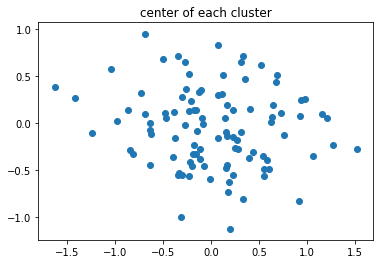

In [433]:
cluster_centers = np.random.multivariate_normal(mean,cov_intercluster,size=number_cluster)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1])
plt.title("center of each cluster")

In [434]:
cluster_stars = []
cluster_names = []
for i,cluster_center in enumerate(cluster_centers):
    cluster_members = cluster_center + np.random.multivariate_normal(mean,cov_intracluster,size=number_cluster_members)
    cluster_stars.append(cluster_members)
    cluster_names.append(np.array([str(i)]*number_cluster_members))
cluser_stars = np.array(cluster_stars)
cluster_names = np.array(cluster_names)

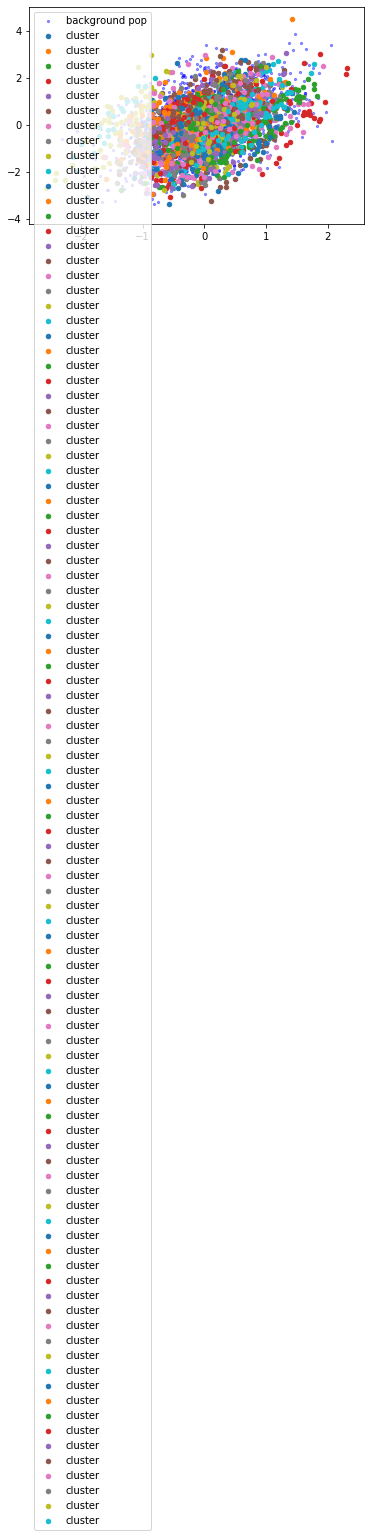

In [435]:
plt.scatter(random_stars[:,0],random_stars[:,1],color="b",alpha=0.4,s=5,label="background pop")
for star_cluster in cluser_stars:
    plt.scatter(star_cluster[:,0],star_cluster[:,1],alpha=1,s=20,label="cluster")
plt.legend()
#stars.reshape(-1,2)

(-1.8, 2)

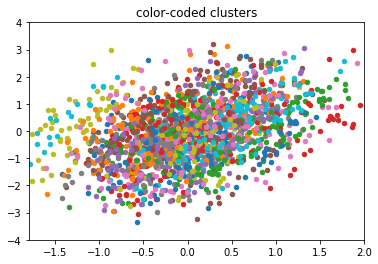

In [436]:
for star_cluster in cluser_stars:
    plt.scatter(star_cluster[:,0],star_cluster[:,1],alpha=1,s=20)
plt.title("color-coded clusters")
#plt.legend()
plt.ylim(-4,4)
plt.xlim(-1.8,2)

### Create visualisations

In [437]:
z = vector.Vector(random_stars.reshape(-1,2))
z_occam = vector.OccamLatentVector(cluster_names.reshape(-1),raw=cluser_stars.reshape(-1,2))


In [455]:
class Fitter():
    def __init__(self,z:vector.Vector,z_occam:vector.OccamLatentVector):
        self.z = z
        self.z_occam = z_occam
        self.whitener = PCA(n_components=self.z.raw.shape[1],whiten=True)
        self.pca = PCA(n_components=self.z.raw.shape[1])        
        #make z look like a unit gaussian
        self.whitener.fit(self.z.centered())
        #pick-up on directions of z_occam which are the most squashed relative to z
        self.pca.fit(self.z_occam.cluster_centered.whitened(self.whitener)())
        
        #self.scaling_factor = 1 #required to set to 1 because self.transform needs scaling factor
        self.scaling_factor = np.std(self.transform(self.z_occam.cluster_centered,scaling=False),axis=0)[None,:]
        
        
        
    def transform(self,vector,scaling=True):
        """transform a vector in a way that unit vector has variance one"""
        transformed_vector  = np.dot(vector.whitened(self.whitener)(),self.pca.components_.T)
        if scaling is True:
            transformed_vector = transformed_vector/self.scaling_factor
        return transformed_vector


In [439]:
fitter = Fitter(z,z_occam)

(-4, 4)

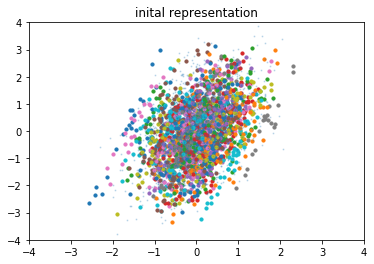

In [440]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z()[:,0],z()[:,1],s=1,alpha=0.2)
plt.title("inital representation")
plt.ylim(-4,4)
plt.xlim(-4,4)

(-4, 4)

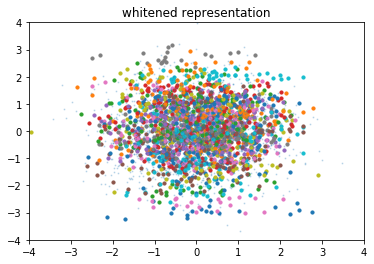

In [441]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.whitened(fitter.whitener).only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z.whitened(fitter.whitener)()[:,0],z.whitened(fitter.whitener)()[:,1],s=1,alpha=0.2)
plt.title("whitened representation")
plt.ylim(-4,4)
plt.xlim(-4,4)


(-4, 4)

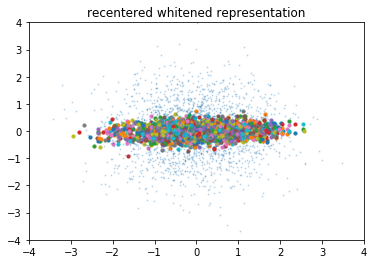

In [442]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.whitened(fitter.whitener).only(cluster_name).centered()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z.whitened(fitter.whitener)()[:,0],z.whitened(fitter.whitener)()[:,1],s=1,alpha=0.2)
plt.title("recentered whitened representation")
plt.ylim(-4,4)
plt.xlim(-4,4)

In [443]:
v_occam =  vector.OccamLatentVector(cluster_names.reshape(-1),raw=fitter.transform(z_occam.centered))
v = vector.Vector(fitter.transform(z.centered))


Distances now encode chemical similarity

(-10, 10)

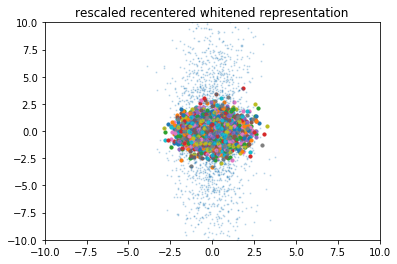

In [444]:
for cluster_name in list(v_occam.registry.keys()):
    members = v_occam.only(cluster_name).centered()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(v()[:,0],v()[:,1],s=1,alpha=0.2)
plt.title("rescaled recentered whitened representation")
plt.ylim(-10,10)
plt.xlim(-10,10)

(-10, 10)

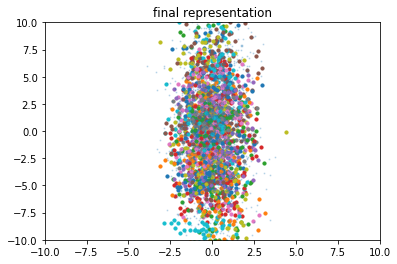

In [445]:
for cluster_name in list(v_occam.registry.keys()):
    members = v_occam.only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(v()[:,0],v()[:,1],s=1,alpha=0.2)
plt.title("final representation")
plt.ylim(-10,10)
plt.xlim(-10,10)

(-10, 10)

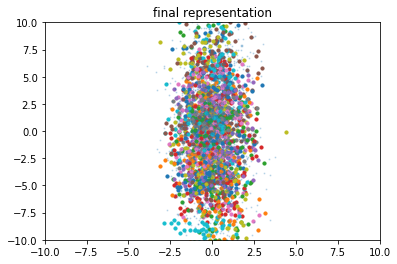

In [446]:
for cluster_name in list(v_occam.registry.keys()):
    members = v_occam.only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(v()[:,0],v()[:,1],s=1,alpha=0.2)
plt.title("final representation")
plt.ylim(-10,10)
plt.xlim(-10,10)

In [147]:
print(inspect.getsource(vector.get_intracluster_distances))

AttributeError: module 'apoNN.src.vectors' has no attribute 'get_intracluster_distances'

In [24]:
print(inspect.getsource(vector.Vector))

class Vector():
    def __init__(self, raw, order=1,interaction_only=True):
        self._raw = raw
        if order>1:
            poly = PolynomialFeatures(order,interaction_only,include_bias=False)
            self._raw = poly.fit_transform(self._raw)

    def __call__(self):
        return self._raw

    def whitened(self,whitener):
        """method that takes a whitening PCA instance and returned a whitened vector"""
        return Vector(whitener.transform(self._raw))
        
    @property
    def raw(self):
        return self._raw
    
    @property
    def centered(self):
        return Vector(self._raw -np.mean(self._raw,axis=0))
    
    @property
    def normalized(self):
        return Vector(self.centered()/np.max(np.abs(self.centered()),0))



In [25]:
z_occam.whitened(fitter.whitener)

In [26]:
print(inspect.getsource(vector.Fitter))

class Fitter():
    def __init__(self,z:Vector,z_occam:OccamLatentVector):
        self.z = z
        self.z_occam = z_occam
        self.whitener = PCA(n_components=self.z.raw.shape[1],whiten=True)
        self.pca = PCA(n_components=self.z.raw.shape[1])        
        #make z look like a unit gaussian
        self.whitener.fit(self.z.centered())
        #pick-up on directions of z_occam which are the most squashed relative to z
        self.pca.fit(self.z_occam.cluster_centered.whitened(self.whitener)())
        
        #self.scaling_factor = 1 #required to set to 1 because self.transform needs scaling factor
        self.scaling_factor = np.std(self.transform(self.z_occam.cluster_centered,scaling=False),axis=0)[None,:]
        
        
        
    def transform(self,vector,scaling=True):
        """transform a vector in a way that unit vector has variance one"""
        transformed_vector  = np.dot(vector.whitened(self.whitener)(),self.pca.components_.T)
        if scaling is Tr

In [467]:
class Fitter():
    def __init__(self,z:vector.Vector,z_occam:vector.OccamLatentVector):
        self.z = z
        self.z_occam = z_occam
        self.whitener = PCA(n_components=self.z.raw.shape[1],whiten=True)
        self.pca = PCA(n_components=self.z.raw.shape[1])        
        #make z look like a unit gaussian
        self.whitener.fit(self.z.centered())
        #pick-up on directions of z_occam which are the most squashed relative to z
        self.pca.fit(self.z_occam.cluster_centered.whitened(self.whitener)())
        
        #self.scaling_factor = 1 #required to set to 1 because self.transform needs scaling factor
        self.scaling_factor = np.std(self.transform(self.z_occam.cluster_centered,scaling=False),axis=0)[None,:]
        self.scaling_factor = np.array([scaling_test(std) for std in fitter.scaling_factor[0]])
        
        
    def transform(self,vector,scaling=True):
        """transform a vector in a way that unit vector has variance one"""
        transformed_vector  = np.dot(vector.whitened(self.whitener)(),self.pca.components_.T)
        if scaling is True:
            transformed_vector = transformed_vector/self.scaling_factor
        return transformed_vector


In [80]:
(1/fitter.scaling_factor-1)

array([[0.33032472, 4.26621292]])

In [448]:
def get_combinations(len_cluster):
    """
    Given a cluster size returns a list containing every pair of index (without repeat) 
    """
    combinations = []
    for idx1 in np.arange(len_cluster):
        for idx2 in np.delete(np.arange(len_cluster),idx1):
            if sorted([idx1,idx2]) not in combinations:
                combinations.append(sorted([idx1,idx2]))
    return combinations




In [449]:
def get_intracluster_distances(z,z_occam,leave_out=True):
    """Measures intracluster distances (between stars in the same cluster) after fitting and transforming.
    INPUTS
    ------
    z: apoNN.vector.Vector
        A vector containing the field star dataset
    z_occam: vector.OccamLatentVector
        A vector containing the occam cluster stars
    leave_out: Boolean
        True corresponds to excluding clusters being evaluated from training so as to avoid overfitting 
    """
    distances = []
    for cluster in list(z_occam.registry.keys()):
        if leave_out is True:
            fitter = Fitter(z,z_occam.without(cluster))
        else:
            fitter = Fitter(z,z_occam)
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        combinations = get_combinations(len(v_centered_occam))
        distances_cluster = []
        for combination in combinations:
            distances_cluster.append(np.linalg.norm(v_centered_occam[combination[0]]-v_centered_occam[combination[1]]))

        distances.append(distances_cluster)
    return distances




In [408]:
def get_intercluster_distances(z,z_occam,leave_out=True,n_random = 200):
    """Measures intercluster distances (between stars in a cluster and stars from the field) after fitting and transforming
    INPUTS
    ------
    z: apoNN.vector.Vector
        A vector containing the field star dataset
    z_occam: vector.OccamLatentVector
        A vector containing the occam cluster stars
    leave_out: Boolean
        True corresponds to excluding clusters being evaluated from training so as to avoid overfitting 
    n_random: Number of field stars each cluste star is compared too.
    """
    distances = []
    for cluster in list(z_occam.registry.keys()):
        if leave_out is True:
            fitter = Fitter(z,z_occam.without(cluster))
        else:
            fitter = Fitter(z,z_occam)
        v_centered_occam = fitter.transform(z_occam.centered.only(cluster))
        v = fitter.transform(fitter.z.centered)
        n_v = len(v)
        distances_cluster = []
        for idx in np.arange(len(v_centered_occam)):
            for _ in np.arange(n_random):
                random_idx = random.randint(0,n_v-1)
                distances_cluster.append(np.linalg.norm(v_centered_occam[idx]-v[random_idx]))

        distances.append(distances_cluster)
    return distances


In [468]:
intra = get_intracluster_distances(z,z_occam)
inter = get_intercluster_distances(z,z_occam)

In [457]:
flatten=lambda l: sum(map(flatten,l),[]) if isinstance(l,list) else [l]

(array([6.35663807e-02, 1.34340206e-01, 1.35980990e-01, 1.23527038e-01,
        1.15223069e-01, 1.10744929e-01, 1.00932239e-01, 9.51654830e-02,
        8.71056309e-02, 8.16070029e-02, 7.36151833e-02, 6.63797253e-02,
        5.96365024e-02, 5.24290577e-02, 4.72025598e-02, 3.93347995e-02,
        3.59051604e-02, 3.01384042e-02, 2.55362047e-02, 2.23306726e-02,
        1.87849780e-02, 1.59036009e-02, 1.31222716e-02, 1.07691470e-02,
        8.66814282e-03, 7.19543896e-03, 5.54665094e-03, 4.74626841e-03,
        3.76980172e-03, 2.87337329e-03, 2.12901753e-03, 1.70881670e-03,
        1.32063118e-03, 1.15655276e-03, 6.48309851e-04, 5.32254384e-04,
        3.32158751e-04, 3.24154925e-04, 1.40066943e-04, 1.28061205e-04,
        1.08051642e-04, 4.40210392e-05, 2.00095633e-05, 2.80133886e-05,
        2.80133886e-05, 8.00382532e-06, 8.00382532e-06, 4.00191266e-06,
        8.00382532e-06, 8.00382532e-06]),
 array([6.09757592e-03, 6.30798866e-01, 1.25550016e+00, 1.88020145e+00,
        2.50490274e+00

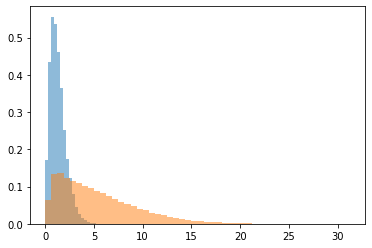

In [452]:
    plt.hist(flatten(intra),alpha=0.5,density=True,bins=20)
    plt.hist(flatten(inter),alpha=0.5,density=True,bins=50)

In [469]:
np.mean(flatten(inter)<np.median(flatten(intra)))

0.11529

In [470]:
np.mean(flatten(inter)<np.mean(flatten(intra)))

0.13545

In [471]:
np.var(flatten(inter))/np.var(flatten(intra))

25.12603850148541

(array([2.97007553e-02, 8.01795176e-02, 1.15046500e-01, 1.30282628e-01,
        1.31361113e-01, 1.24785181e-01, 1.14222489e-01, 1.04415140e-01,
        9.48137943e-02, 8.56608076e-02, 7.90162078e-02, 7.03842869e-02,
        6.24228849e-02, 5.66911602e-02, 5.04949194e-02, 4.41128721e-02,
        3.77792961e-02, 3.36592403e-02, 2.92039251e-02, 2.51081049e-02,
        2.10122847e-02, 1.78091432e-02, 1.45736876e-02, 1.18552587e-02,
        1.03970820e-02, 8.40168245e-03, 6.80213137e-03, 5.79635304e-03,
        4.65323951e-03, 3.61918629e-03, 2.47203349e-03, 2.31854122e-03,
        1.56723692e-03, 1.33699851e-03, 9.49228546e-04, 8.28050434e-04,
        5.04908801e-04, 4.72594638e-04, 2.90827470e-04, 2.14081332e-04,
        1.49453005e-04, 1.21178112e-04, 7.27068674e-05, 4.03927041e-05,
        4.84712449e-05, 1.61570816e-05, 2.42356225e-05, 1.21178112e-05,
        4.03927041e-06, 4.03927041e-06]),
 array([9.24370891e-03, 6.28167363e-01, 1.24709102e+00, 1.86601467e+00,
        2.48493832e+00

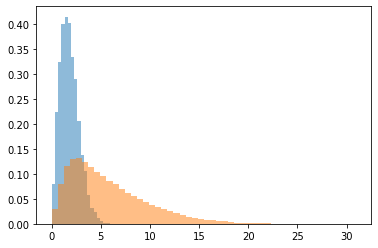

In [458]:
    plt.hist(flatten(intra),alpha=0.5,density=True,bins=20)
    plt.hist(flatten(inter),alpha=0.5,density=True,bins=50)
    #plt.hist(chi_samples,alpha=0.5,density=True,bins=20)
    #plt.hist(dist,alpha=0.3,density=True,bins=50)

In [466]:
np.mean(flatten(inter)<np.median(flatten(intra)))

0.121035

In [460]:
np.mean(flatten(inter)<np.mean(flatten(intra)))

0.1337475

In [464]:
np.var(flatten(inter))/np.var(flatten(intra))

17.513534673113046

In [245]:
chi_samples = np.random.chisquare(3,(5000))

In [246]:
chi_samples

array([5.96945737, 2.03464489, 1.19753387, ..., 5.89084031, 2.88922294,
       1.69424829])

In [211]:
v_centered_occam = fitter.transform(z_occam.cluster_centered)


(array([0.0013637 , 0.0013637 , 0.0013637 , 0.00681851, 0.0013637 ,
        0.00818222, 0.01090962, 0.00818222, 0.01090962, 0.02454665,
        0.03954737, 0.04091108, 0.06818513, 0.07773104, 0.10091399,
        0.15546209, 0.19500946, 0.19364576, 0.23864794, 0.3218338 ,
        0.29183234, 0.35047155, 0.38456412, 0.39956484, 0.38183671,
        0.40365595, 0.36138117, 0.38456412, 0.36274488, 0.30137826,
        0.28228643, 0.27546791, 0.22364722, 0.215465  , 0.17319022,
        0.12000582, 0.1050051 , 0.07773104, 0.07909475, 0.04772959,
        0.02045554, 0.02181924, 0.01500073, 0.01636443, 0.00681851,
        0.00545481, 0.0013637 , 0.        , 0.0013637 , 0.0013637 ]),
 array([-3.73223828, -3.58557873, -3.43891918, -3.29225963, -3.14560008,
        -2.99894054, -2.85228099, -2.70562144, -2.55896189, -2.41230234,
        -2.26564279, -2.11898324, -1.97232369, -1.82566414, -1.67900459,
        -1.53234504, -1.38568549, -1.23902595, -1.0923664 , -0.94570685,
        -0.7990473 , -0.65

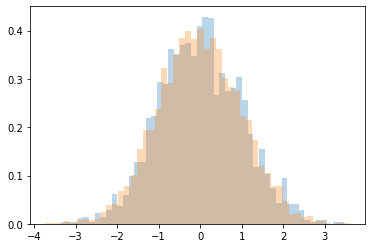

In [215]:
plt.hist(v_centered_occam[:,1],alpha=0.3,density=True,bins=50)
plt.hist(np.random.normal(size=5000),alpha=0.3,density=True,bins=50)

([array([0.00142548, 0.        , 0.00142548, 0.00427644, 0.0071274 ,
         0.00570192, 0.0071274 , 0.00997835, 0.01140383, 0.01995671,
         0.02565862, 0.03991341, 0.05987012, 0.07555039, 0.0883797 ,
         0.14682434, 0.15395174, 0.1496753 , 0.18816324, 0.23092761,
         0.25088431, 0.32073279, 0.34496593, 0.38915578, 0.43334563,
         0.3948577 , 0.41481441, 0.41196345, 0.3948577 , 0.34781689,
         0.37917743, 0.2722665 , 0.26228815, 0.2451824 , 0.21524734,
         0.16535557, 0.14539886, 0.13684599, 0.08552874, 0.07840135,
         0.0612956 , 0.03706246, 0.0342115 , 0.01710575, 0.02280766,
         0.00997835, 0.01140383, 0.00997835, 0.00570192, 0.00142548]),
  array([0.00285096, 0.        , 0.00285096, 0.        , 0.00427644,
         0.00997835, 0.00427644, 0.01853123, 0.00997835, 0.01995671,
         0.03136054, 0.05274273, 0.07555039, 0.08267779, 0.10405997,
         0.13399503, 0.16250461, 0.13969695, 0.2180983 , 0.2451824 ,
         0.26371363, 0.31075443,

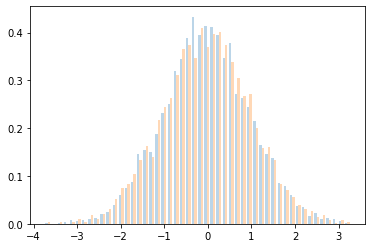

In [225]:
plt.hist(np.random.normal(size=(5000,2)),alpha=0.3,density=True,bins=50)

In [238]:
normal_samples = np.random.normal(size=(10000,2))
normal_samples2 = np.random.normal(size=(10000,2))

In [239]:
normal_samples.shape

(10000, 2)

In [240]:
dist = np.linalg.norm(normal_samples2 - normal_samples,axis=1)

(array([0.04160291, 0.09205749, 0.14782309, 0.19916285, 0.27174664,
        0.30361269, 0.3257419 , 0.35760795, 0.3815075 , 0.42134007,
        0.43461759, 0.43461759, 0.43904343, 0.4009812 , 0.40983288,
        0.36911514, 0.39035918, 0.38327783, 0.36026346, 0.34167493,
        0.27440214, 0.27086147, 0.26200979, 0.21067003, 0.18057431,
        0.16198578, 0.15667477, 0.12569389, 0.11153119, 0.08763165,
        0.08763165, 0.06196177, 0.0584211 , 0.06815795, 0.05488043,
        0.03452156, 0.03098089, 0.02212921, 0.01858853, 0.01327752,
        0.01239235, 0.00619618, 0.00973685, 0.01062202, 0.0026555 ,
        0.00531101, 0.00442584, 0.        , 0.        , 0.00177034]),
 array([0.01192765, 0.12490052, 0.2378734 , 0.35084628, 0.46381916,
        0.57679204, 0.68976492, 0.8027378 , 0.91571067, 1.02868355,
        1.14165643, 1.25462931, 1.36760219, 1.48057507, 1.59354794,
        1.70652082, 1.8194937 , 1.93246658, 2.04543946, 2.15841234,
        2.27138522, 2.38435809, 2.49733097, 2.

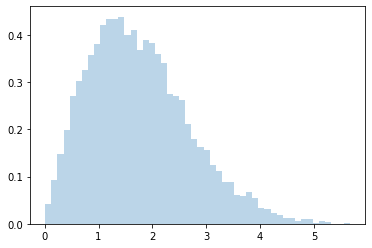

In [241]:
plt.hist(dist,alpha=0.3,density=True,bins=50)

In [281]:
def scaling_test(a,b=1):
    return np.sqrt(np.abs(a**2*b**2/(b**2-a**2)))

In [298]:
scaling_test(0.5)

0.5773502691896257

In [269]:
np.linspace()

1.0101010101010102

In [288]:
import scipy.stats
normal  = scipy.stats.norm(0, 1)

In [362]:
x_vals = np.linspace(-5,5,50)
y_vals = [scipy.stats.norm(0, 0.5).pdf(x)/scipy.stats.norm(0, 1).pdf(x) for x in x_vals]
y2_vals = [2.9*scipy.stats.norm(0., 0.5773502691896257).pdf(x) for x in x_vals]

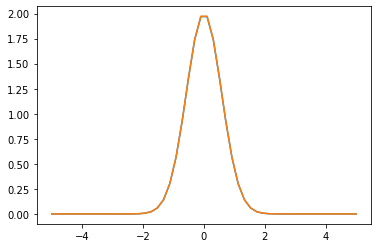

In [363]:
plt.plot(x_vals,y_vals)
plt.plot(x_vals,y2_vals)

In [341]:
0.5**2/(1-0.5**2)

0.3333333333333333

In [397]:
scaling_test(0.1)

0.10050378152592122

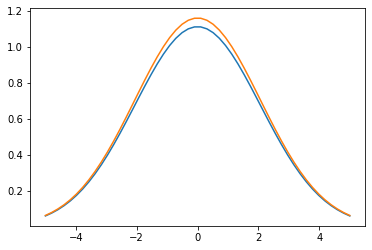

In [376]:
x_vals = np.linspace(-5,5,50)
y_vals = [scipy.stats.norm(0, 0.9).pdf(x)/scipy.stats.norm(0, 1).pdf(x) for x in x_vals]
y2_vals = [6*scipy.stats.norm(0., 2.064741604835056).pdf(x) for x in x_vals]
plt.plot(x_vals,y_vals)
plt.plot(x_vals,y2_vals)

In [394]:
fitter.scaling_factor

array([[0.67354479, 0.22707482]])

In [404]:
np.array([scaling_test(std) for std in fitter.scaling_factor[0]])

array([0.91124679, 0.23316573])

In [400]:
scaling_test(fitter.scaling_factor[0])

array([0.91124679, 0.23316573])

In [402]:
fitter.scaling_factor[=

SyntaxError: unexpected EOF while parsing (<ipython-input-402-33dbccfab931>, line 1)